# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Group

Enrollment Status (109A, 121A, 209A, or E109A): AC209

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import seaborn as sns
%matplotlib inline



D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

5. We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
np.random.seed(9001)
df = pd.read_csv('dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
12,0,17,-229,79,218,-262,-404,325,-201,6,...,225,1020,-109,209,-51,1434,255,53,545,-16
13,0,-144,-199,-157,132,-151,-347,-118,-24,126,...,103,595,-12,36,26,208,113,-8,22,-22


In [4]:
Y_train = data_train['Cancer_type'].reset_index(drop=True)
X_train = data_train.drop('Cancer_type', axis=1).reset_index(drop=True)

Y_test = data_test['Cancer_type'].reset_index(drop=True)
X_test = data_test.drop('Cancer_type', axis=1).reset_index(drop=True)

X_cols = X_train.columns

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler((0, 1))

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_cols)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_cols)

In [7]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.624055,0.554310,0.574792,0.566406,0.419684,0.593750,0.455662,0.583820,0.542561,0.540228,...,0.378586,0.392435,0.636270,0.288934,0.637384,0.358404,0.300761,0.722114,0.193695,0.561800
std,0.202594,0.255539,0.198218,0.298191,0.205918,0.226106,0.220498,0.212797,0.234644,0.217127,...,0.239203,0.239999,0.218186,0.191286,0.214031,0.232741,0.225406,0.192814,0.231173,0.182029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.528915,0.386207,0.460873,0.333097,0.257704,0.455305,0.291638,0.457944,0.352668,0.395665,...,0.186066,0.226173,0.508197,0.193369,0.537037,0.196229,0.122391,0.638889,0.078367,0.456157
50%,0.642349,0.563793,0.577562,0.559659,0.425270,0.598837,0.452265,0.620327,0.558005,0.535282,...,0.378689,0.360704,0.685012,0.233301,0.622222,0.314657,0.279565,0.741319,0.099325,0.563433
75%,0.738434,0.781034,0.660665,0.803267,0.516179,0.726381,0.570906,0.731308,0.726798,0.669607,...,0.529508,0.481488,0.800937,0.358180,0.790741,0.503983,0.380870,0.821181,0.222487,0.695896
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
X_train_ALL = X_train[Y_train==0]
X_train_AML = X_train[Y_train==1]

In [9]:
heatmap_cols = ["D49818_at", "M23161_at", "hum_alu_at", "AFFX-PheX-5_at", "M15990_at"]

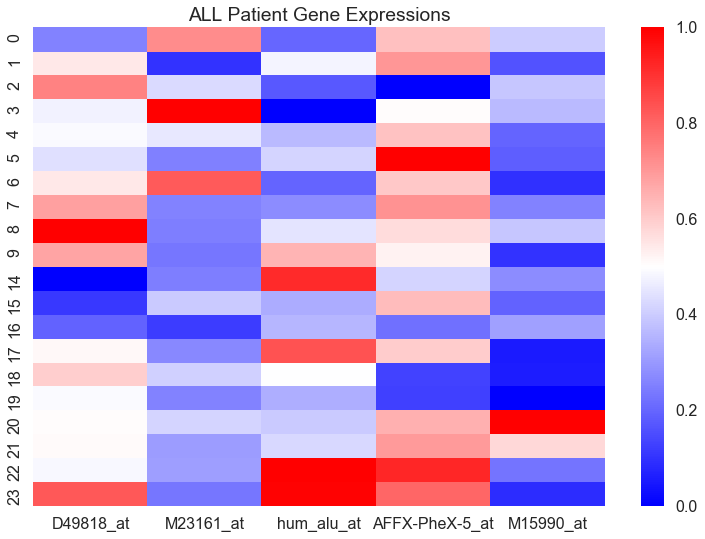

In [10]:
sns.set_context('poster')
sns.heatmap(X_train_ALL[heatmap_cols], cmap='bwr')
plt.title('ALL Patient Gene Expressions')
plt.show()

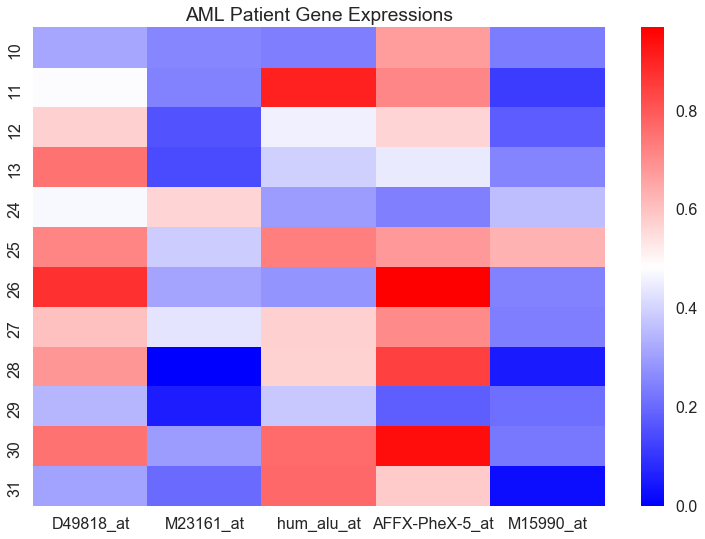

In [11]:
sns.set_context('poster')
sns.heatmap(X_train_AML[heatmap_cols], cmap='bwr')
plt.title('AML Patient Gene Expressions')
plt.show()

In [12]:
pca = PCA(n_components=2)
Z_train_PCA = pca.fit_transform(X_train)

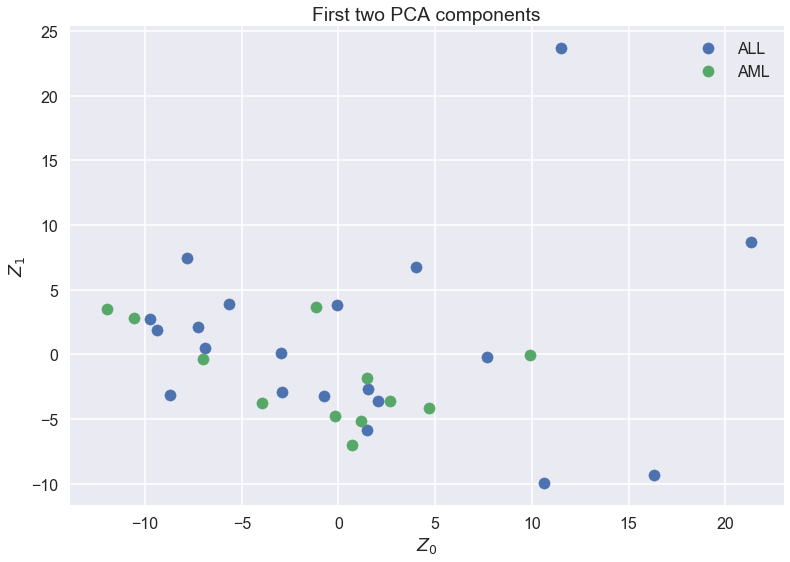

In [13]:
plt.scatter(Z_train_PCA[Y_train == 0, 0], Z_train_PCA[Y_train == 0, 1], label='ALL')
plt.scatter(Z_train_PCA[Y_train == 1, 0], Z_train_PCA[Y_train == 1, 1], label='AML')
plt.legend(loc='best')
plt.title('First two PCA components')
plt.xlabel('$Z_0$')
plt.ylabel('$Z_1$')
plt.show()

Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?
> The coefficients of the model will not be unique if there are more predictors than observations.

By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.
> These five genes' expressions are very similar in both ALL and AML cases - None of them can be used alone to discriminate between ALL and AML.

How well do the top two principal components discriminate between the two classes?
> The top two principal components provide minimum information on discriminating between ALL and AML.

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `D29963_at`.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').

4. Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



In [14]:
Linear_model = OLS(Y_train, sm.add_constant(X_train['D29963_at']))
Linear_result = Linear_model.fit()
Y_train_pred = Linear_result.predict(sm.add_constant(X_train['D29963_at']))

In [15]:
print('Linear Regression training scores: %.3f' % (Linear_result.rsquared))

Linear Regression training scores: 0.100


In [16]:
Y_train_pred_class = Y_train_pred.apply(lambda y: 1 if y > 0.5 else 0)
print('Linear Regression training scores (classified): %.3f' % ((Y_train_pred_class == Y_train).mean()))

Linear Regression training scores (classified): 0.719


In [17]:
Y_test_pred = Linear_result.predict(sm.add_constant(X_test['D29963_at']))
Y_test_pred_class = Y_test_pred.apply(lambda y: 1 if y > 0.5 else 0)
print('Linear Regression testing scores (classified): %.3f' % ((Y_test_pred_class == Y_test).mean()))

Linear Regression testing scores (classified): 0.854


In [18]:
Logistic_model = LogisticRegression(C=1000000)
Logistic_result = Logistic_model.fit(X_train['D29963_at'].values.reshape(-1, 1), Y_train)

In [19]:
print('Logistic Regression training scores: %.3f' % 
      (Logistic_result.score(X_train['D29963_at'].values.reshape(-1, 1), Y_train)))
print('Logistic Regression testing scores: %.3f' % 
      (Logistic_result.score(X_test['D29963_at'].values.reshape(-1, 1), Y_test)))

Logistic Regression training scores: 0.719
Logistic Regression testing scores: 0.829


In [20]:
X = np.linspace(0, 1, 20)
Y = Logistic_result.predict_proba(X.reshape(-1, 1))

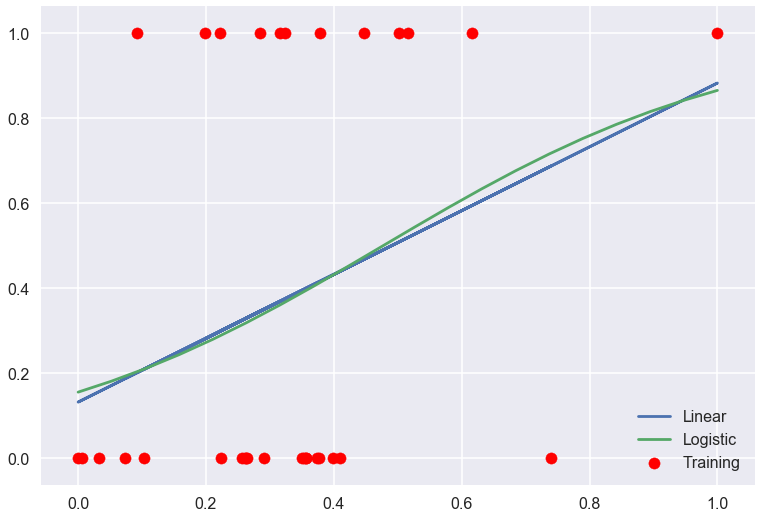

In [21]:
plt.scatter(X_train['D29963_at'], Y_train, label='Training', color='r')
plt.plot(X_train['D29963_at'], Y_train_pred, label='Linear')
plt.plot(X, Y[:, 1], label='Logistic')
plt.legend(loc='best')
plt.show()

Based on the plots and the accuracy, the performance of the linear model and the logistic model are similar to each other

## Part (c): Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

2. "Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?"

In [22]:
# starter code
from HW5_functions import visualize_prob

In [23]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1))+0.1, ypos[:,1], 'bx', label = 'ALL')
    neg_handle = ax.plot(np.zeros((nneg,1))-0.1, yneg[:,1], 'rx', label = 'AML')
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])
    ax.set_xlim([-0.5, 0.5])

In [24]:
MLG_model = LogisticRegression(C=100000)
MLG_results = MLG_model.fit(X_train, Y_train)

In [25]:
print('Multiple Logistic Regression training scores: %.3f' % (MLG_results.score(X_train, Y_train)))
print('Multiple Logistic Regression testing scores: %.3f' % (MLG_results.score(X_test, Y_test)))

Multiple Logistic Regression training scores: 1.000
Multiple Logistic Regression testing scores: 0.927


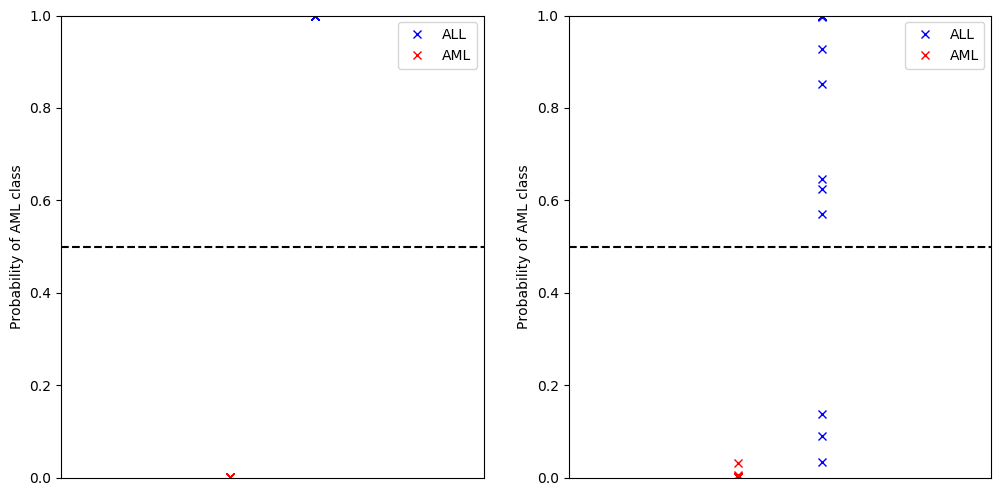

In [26]:
sns.reset_defaults()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
visualize_prob(MLG_results, X_train.values, Y_train.values, ax1)
visualize_prob(MLG_results, X_test.values, Y_test.values, ax2)

How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?
> The training accuracy is 100% and the testing accuracy is 92.7%, both much higher than the single gene model.

Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?
> The testing set is more spread then the training set. There are some points in the testing set whose probability is close to 0.5, which indicate less conclusive prediction as they can easily be categorized into the other group if a threshold other than 0.5 was used.

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



In [27]:
n_iter = 100
coefs = np.zeros((n_iter, X_train.shape[1]+1)) # all coefficients and a intercept
for i in range(n_iter):
    index = np.random.choice(len(X_train), replace=True, size=100)
    X_train_bt = X_train.iloc[index]
    Y_train_bt = Y_train.iloc[index]
    
    MLG_model = LogisticRegression(C=100000)
    MLG_results = MLG_model.fit(X_train_bt, Y_train_bt)
    
    coefs[i, 0] = MLG_results.intercept_[0]
    coefs[i, 1:] = MLG_results.coef_[0]

#### Method 1: Use percentile ####

In [28]:
coefs_quantiles = np.percentile(coefs, [2.5, 97.5], axis=0).T
coef_has_0 = (coefs_quantiles[:,0] < 0) & (coefs_quantiles[:,1] > 0)
print('Number of coefficients that are significantly not 0: %d' % 
      coef_has_0.sum())
print('Percentage of coefficients that are significantly not 0: %.1f%%' % 
      ((1-coef_has_0.mean())*100))

Number of coefficients that are significantly not 0: 2088
Percentage of coefficients that are significantly not 0: 70.7%


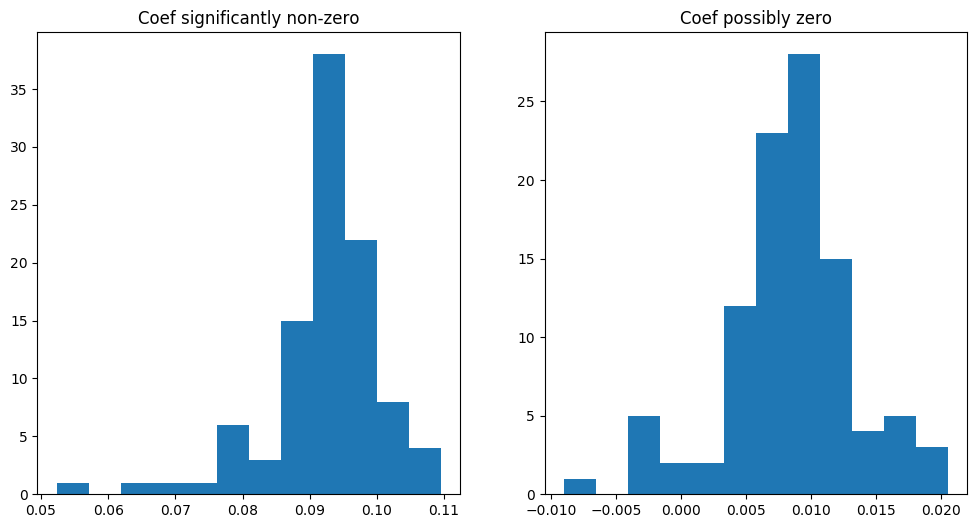

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(coefs[:, np.where(np.invert(coef_has_0))[0][-1]], bins=12)
ax1.set_title('Coef significantly non-zero')
ax2.hist(coefs[:, np.where(coef_has_0)[0][-1]], bins=12)
ax2.set_title('Coef possibly zero')
plt.show()

#### Method 2: Use t-test ####

In [30]:
# A two-sided test for the null hypothesis that 
# the expected value (mean) of a sample of 
# independent observations a is equal to the given population mean, popmean
# e.g. t, p = ttest_1samp(a, popmean)
from scipy.stats import ttest_1samp

In [31]:
pvalues = np.ones(X_train.shape[1]+1)

In [32]:
# Test if any of the coefficient is 0
for i in range(len(pvalues)):
    pvalues[i] = ttest_1samp(coefs[:, i], 0)[1]

In [33]:
print('Number of coefficients that are significantly not 0: %d' % 
      (pvalues < 0.05).sum())
print('Percentage of coefficients that are significantly not 0: %.1f%%' % 
      (((pvalues < 0.05).sum()/len(pvalues))*100))

Number of coefficients that are significantly not 0: 6939
Percentage of coefficients that are significantly not 0: 97.3%


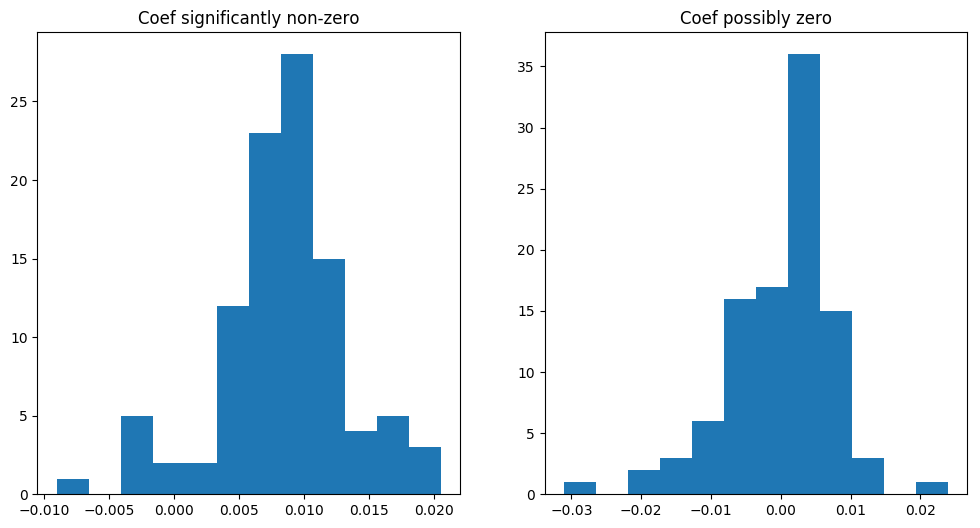

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(coefs[:, np.where(pvalues < 0.05)[0][-1]], bins=12)
ax1.set_title('Coef significantly non-zero')
ax2.hist(coefs[:, np.where(pvalues > 0.05)[0][-1]], bins=12)
ax2.set_title('Coef possibly zero')
plt.show()

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 


#### Part 1 ####

In [35]:
pca = PCA()
Z_train_all = pca.fit_transform(X_train)
Z_test_all = pca.transform(X_test)

In [36]:
n_comp = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0] + 1
n_comp

24

In [37]:
pca = PCA(n_components=n_comp)
Z_train = pca.fit_transform(X_train)

MLG_model_PCA = LogisticRegression(C=100000)
MLG_results_PCA = MLG_model_PCA.fit(Z_train, Y_train)

In [38]:
print('PCA fisrt %d components training scores: %.3f' % (n_comp, MLG_results_PCA.score(Z_train, Y_train)))

PCA fisrt 24 components training scores: 1.000


In [39]:
Z_test = pca.transform(X_test)
print('PCA fisrt %d components testing scores: %.5f' % (n_comp, MLG_results_PCA.score(Z_test, Y_test)))

PCA fisrt 24 components testing scores: 0.92683


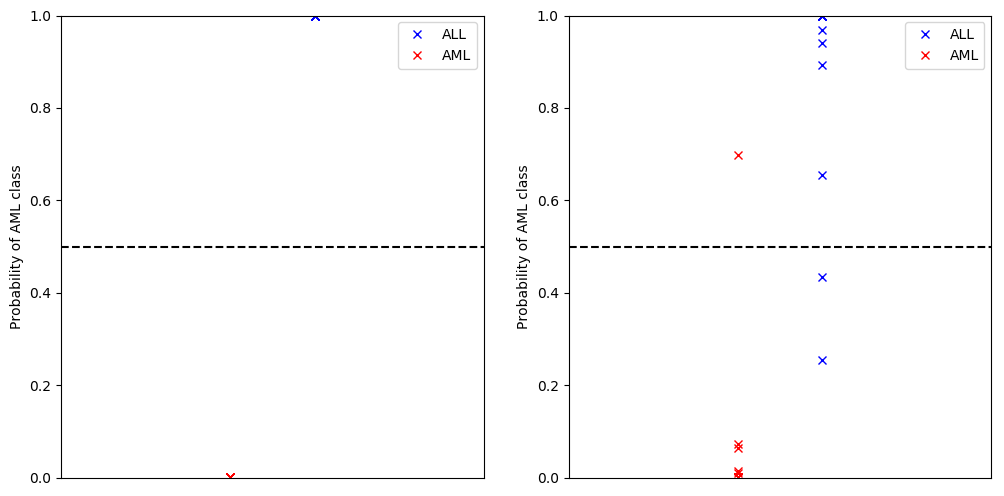

In [40]:
sns.reset_defaults()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
visualize_prob(MLG_results_PCA, Z_train, Y_train.values, ax1)
visualize_prob(MLG_results_PCA, Z_test, Y_test.values, ax2)

#### Part 2 ####

In [41]:
# Use Logistic Regression with cross-validation to computation the scores on the training set
# Choose the minimal number of components that gives the highest training score (i.e. 1)
scores = []
for i in range(Z_train_all.shape[1]):
    MLG_model_PCA_CV = LogisticRegressionCV(Cs=[100000], cv=5)
    MLG_results_PCA_CV = MLG_model_PCA_CV.fit(Z_train_all[:, 0:i+1], Y_train)
    scores.append(MLG_results_PCA_CV.score(Z_train_all[:, 0:i+1], Y_train))

In [42]:
n_comp_CV = np.array(scores).argmax()+1

In [43]:
pca_CV = PCA(n_components=n_comp_CV)
Z_train_CV = pca_CV.fit_transform(X_train)

MLG_model_PCA_CV = LogisticRegressionCV(Cs=[100000], cv=5)
MLG_results_PCA_CV = MLG_model_PCA_CV.fit(Z_train_CV, Y_train)

In [44]:
print('PCA fisrt %d components training scores (CV): %.3f' % (n_comp_CV, MLG_results_PCA_CV.score(Z_train_CV, Y_train)))

PCA fisrt 5 components training scores (CV): 1.000


In [45]:
Z_test_CV = pca_CV.transform(X_test)
print('PCA fisrt %d components testing scores (CV): %.5f' % (n_comp_CV, MLG_results_PCA_CV.score(Z_test_CV, Y_test)))

PCA fisrt 5 components testing scores (CV): 0.78049


D:\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


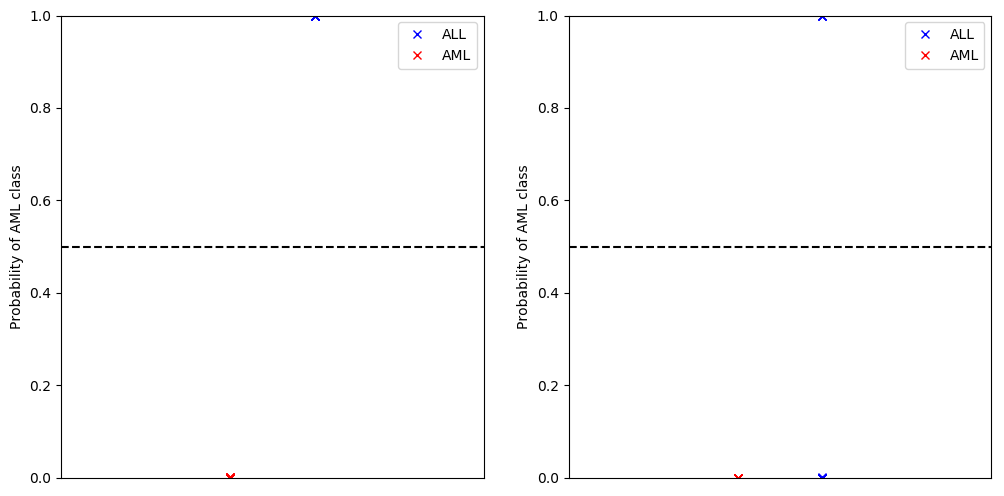

In [46]:
sns.reset_defaults()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
visualize_prob(MLG_results_PCA_CV, Z_train_CV, Y_train.values, ax1)
visualize_prob(MLG_results_PCA_CV, Z_test_CV, Y_test.values, ax2)

---
 

1. How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?
> They are identical

2. Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components, and comment on whether you get better test performance than the model fitted above (explain your observations). 
> Through cross-validation we can find that we only need 5 principle components to achieve a training score of 1.0. However, if only 5 principle components are used, the testing set accuracy drops to 0.78 instead of 0.927 when 24 components are used.

3. Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 
> The plots in part 1 (24 principle components) are very similar to the models in Part (c), in which the false predictions in the testing set have probabilities close to 0.5. However, the plots in part 2 are completely different, where the false predictions of AML have probabilities to be almost 0.

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

(2) Simplify your result from (1) based on properties of the matrices $Q$.

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

(4) Use your results from (3) to finally fully simplify your expression from (2).

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?

(1)
\begin{align}
\parallel XQ- XQ_m \parallel ^2 &= (XQ-XQ_m)^T(XQ- XQ_m)\\  
&= (Q^TX^T-{Q_m}^TX^T)(XQ- XQ_m) \\
&= Q^TX^TXQ-{Q_m}^TX^TXQ - Q^TX^T XQ_m-{Q_m}^TX^T XQ_m \\
\end{align}


(2)
Since
\begin{align}
Q^TQ = 1\\
\\
\parallel XQ- XQ_m \parallel ^2 &= Q^TX^TXQ-{Q_m}^TX^TXQ - Q^TX^T XQ_m-{Q_m}^TX^T XQ_m\\
&= Q^T Q \Lambda Q^TQ-{Q_m}^TQ \Lambda Q^TQ - Q^TQ \Lambda Q^TQ_m-{Q_m}^TQ \Lambda Q ^TQ_m\\
&= \Lambda -{Q_m}^TQ \Lambda  - \Lambda Q ^TQ_m+{Q_m}^TQ \Lambda Q ^TQ_m 
\end{align}

(3)
$${Q_m}^TQ = Q^T Q_m = \left[ \begin{array}{cccc}
x_{11}=1 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & x_{22}=1 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  x_{33}=1 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  \ldots & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  0 & x_{mm}=1 & 0 & \ldots&0 \\
0 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\\
\vdots & \vdots &  \vdots &  \vdots & \vdots & \vdots &\ldots & 0\\
0 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\end{array} \right]$$

(4)
$$\Lambda -{Q_m}^TQ \Lambda  - \Lambda Q ^TQ_m-{Q_m}^TQ \Lambda Q ^TQ_m = \\ 
\left[ \begin{array}{cccc}
\lambda_1 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & \lambda_2 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  \lambda_3 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  \lambda_4 & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  0 & \lambda_5 & 0 & \ldots&0 \\
0 & 0 &  0 &  0 & 0 & \lambda_6 &\ldots & 0\\
\vdots & \vdots &  \vdots &  \vdots & \vdots & \vdots &\ldots & 0\\
0 & 0 &  0 &  0 & 0 & 0 &\ldots & \lambda_p\end{array} \right] - \left[ \begin{array}{cccc}
\lambda_1 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & \lambda_2 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  \lambda_3 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  \lambda_4 & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  0 & \ddots & 0 & \ldots&0 \\
0 & 0 &  0 &  0 & 0 & \lambda_m &\ldots & 0\\
\vdots & \vdots &  \vdots &  \vdots & \vdots & \vdots &\ldots & 0\\
0 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\end{array} \right]  =  \left[ \begin{array}{cccc}
0 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  \ddots &  0 & 0 & 0 &\ldots & 0\\
0 & 0 &  0 & 0  & 0 & 0 &\ldots & 0\\
0 & 0 &  0 &  0 & \lambda_{m+1}=1 & 0 & \ldots&0 \\
0 & 0 &  0 &  0 & 0 & \lambda_{m+2}=1  &\ldots & 0\\
\vdots & \vdots &  \vdots &  \vdots & \vdots & \vdots &\ldots & 0\\
0 & 0 &  0 &  0 & 0 & 0 &\ldots & \lambda_{p}=1\end{array} \right]$$

(5)
$$ \parallel XQ- {XQ_m}\parallel ^2  = {\rm trace} (A^T A) = \sum_{i=m+1}^{p}{\lambda_i}$$

(6)
The results from (5) essentially tell us that the total squared reconstruction error is just the sum of the smallest (p-m) eigenvalues, given p the number of features and m the number of components selected. Thus, minimizing the total squared reconstruction error is equivalent of maximizing the sum of the selected eigenvalues. Hence, selecting the m components with highest eigenvalues in the PCA procedure makes sense.